# ** Описание **
Построить графики распределения в спам и не спам множествах следующих признаков:

1	Количество слов на странице

2	Средняя длинна слова

3	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)

4	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)

5	Коэффициент сжатия

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

И отправить первое решение в соревнование https://kaggle.com/join/antispam_infopoisk
На основании одного из указанных выше признаков попытаться разделить мн-во, так чтобы score в соревновании был больше 0.55

При выполнении всех этих условия в течении семинара +1 балл к ДЗ

Описание ДЗ и правил выставления за него баллов в https://inclass.kaggle.com/c/antispam-infopoisk  
Срок для ИТМО - 1 неделя  
Срок для Техносферы - 3 недели  

In [1]:
import base64
import zlib
import csv
from collections import namedtuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

In [3]:
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

ParsingResult = namedtuple('ParsingResult', ['title_text', 'links_text', 'text'])
def parse_html(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    title = "" if soup.title is None or soup.title.string is None else soup.title.string
    links = [link.string for link in soup.findAll('a') if link.string is not None]
    [s.extract() for s in soup(['script', 'style'])]
    full_text = soup.get_text()
    return ParsingResult(title, links, full_text)

In [4]:
def easy_tokenizer(text):
    text = text.lower()
    word = ""
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = ""
    if word: yield word
        
def text2words(text, tokenizer=easy_tokenizer):
    return tokenizer(text.lower())

In [5]:
WordsFeaturesResult = namedtuple('WordsFeaturesResult', ['title_text', 'links_text', 'text_words'])
def get_words_features(url, html_data):
    pr = parse_html(html_data)
    return WordsFeaturesResult(pr.title_text, pr.links_text, list(text2words(pr.text)))

In [6]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_raw_csv(input_file_name, calc_features_f):    
    with open(input_file_name)  as input_file:
        headers = input_file.readline()
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)        

In [7]:
def raw_csv2text_csv(name):
    raw_csv_file = '/home/kirill/ssd-pool/kaggle_{}_data_tab.csv'.format(name)
    with open('text_features_{}.csv'.format(name) , 'w') as fout:
        writer = csv.writer(fout)
        writer.writerow(['doc_id','is_spam', 'url', 'title_text', 'links_text', 'text_words'])
        for doc in load_raw_csv(raw_csv_file, get_words_features):
            writer.writerow([doc.doc_id, doc.is_spam, doc.url, 
                             doc.features.title_text, doc.features.links_text, doc.features.text_words])

In [36]:
#raw_csv2text_csv('train')
#raw_csv2text_csv('test')

In [8]:
def split_text_to_list(raw):
    rv = [i[1:-1].strip() for i in raw[1:-1].split(", ")]
    return rv

In [10]:
train_texts = pd.read_csv("text_features_train.csv")
train_texts.links_text = train_texts.links_text.apply(split_text_to_list)
train_texts.text_words = train_texts.text_words.apply(split_text_to_list)
train_texts['words_num'] = train_texts.text_words.apply(lambda x: len(x))
train_texts['avg_word_len'] = train_texts.apply(
    lambda row: sum([len(w) for w in row['text_words']])/float(row['words_num'])
    , axis=1)
train_texts['title_words_num'] = train_texts.title_text.apply(lambda x: len(list(text2words(str(x)))))
train_texts['anchor_words_num'] = train_texts.links_text.apply(lambda x: sum([len(i) for i in x]))

In [11]:
train_texts.head()

,doc_id,is_spam,url,title_text,links_text,text_words,words_num,avg_word_len,title_words_num,anchor_words_num
0,-9222401963271173253,False,http://lawleader.ru/docs/32/,"Договор займа, договоры, договора","[Главная, О компании, Услуги, Бизнес-договоры,...","[договор, займа, договоры, договора, главная, ...",2914,6.580645,4,1303
1,-9221399504663603656,False,http://alterhost.ruwww.alterhost.ruwww.user.kz...,UzRu – миры общения,"[Главная, Форумы и обсуждения, Блоги, Творчест...","[uzru, миры, общения, главная, форумы, и, обсу...",400,5.440000,3,1252
2,-9219733223042265364,False,http://www.ferio.ru/c_1-acura-legend.html,FERIO.RU: ремонт и автозапчасти Acura Legend,"[\nСанкт-Петербург, \nСибирский ФО, \nЮжный ФО...","[ferio, ru, ремонт, и, автозапчасти, acura, le...",1203,5.133832,7,1970
3,-9218561774155397294,False,http://fshops.otzyv.ru/read.php?id=277,Как повесить штору?,"[Форумы, Туризм, Кино, Авто, Магазины, Контакт...","[как, повесить, штору, как, повесить, штору, ф...",571,5.264448,3,973
4,-9216163564171210203,True,http://penhea895.narod.ru/familiya-shushmarche...,Фамилия Шушмарченко - французские фамилии,"[Рамблер, Поиск, ещё, Авторамблер, Аудио, Афиш...","[фамилия, шушмарченко, французские, фамилии, р...",447,6.004474,4,932


In [ ]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

In [32]:
def plot_distribution(feature, bins = range(0,3000,10)):
    spam_data = train_texts[train_texts['is_spam']][feature]
    not_spam_data = train_texts[train_texts['is_spam'] == False][feature]
    plt.hist(spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
    plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
    plt.title('feature')
    plt.legend()
    plt.show()

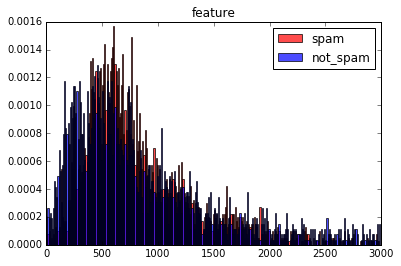

In [31]:
plot_distribution('words_num')